# Pandas Reshaping 

In [178]:
%matplotlib inline
import pandas as pd
import glob
import datetime
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(['seaborn-poster', 'seaborn-white'])

## Vermont project

### Characteristic

<hr>

Two feeders

Two seasons

1000 Waterheaters

Several control algorithms

Sometimes solar and batteries... 

**Many simulations**

### Questions

<hr>

What happends to the peak load?

What happends to the voltage?

What happends to the comfort of the customer?

## The comfort data 

Original files live on peregrine

1 minute resolution for 14 days

One file per attribute (e.g. flow rate, water temperature)

This dataset is a collection of events where:

1. flow rate: **positive demand** (demand > 0) and **shower demand** (demand > 0.4)
2. temperature was below **110** and **105**

We use a `shift` value from the peak of a particular days to make the results align.

<br>


*Collected into a standard form for each simulation and concatenated into a single file*


<br>

The data

In [34]:
df = pd.read_csv("data/comfort_data.csv")

# limit the data a bit...
qry = ["solar==0",
       "days==14",
       "strategy in ['no_control', 'smooth', 'single_bucket']"]

df = df.query(" and ".join(qry))
df.timestamp = pd.to_datetime(df.timestamp)
df.shape

(510680, 14)

In [35]:
df.head()

,timestamp,name,value,attribute,feeder,solar,num_houses,season,strategy,control,days,shift,day,month
0,2013-08-05 06:40:00,zmq_waterheater_427,104.505,shower demand 105,one,0,1000,summer,no_control,0,14,-9.333333,5,8
1,2013-08-05 06:41:00,zmq_waterheater_427,103.360,shower demand 105,one,0,1000,summer,no_control,0,14,-9.316667,5,8
2,2013-08-05 06:42:00,zmq_waterheater_427,102.255,shower demand 105,one,0,1000,summer,no_control,0,14,-9.300000,5,8
3,2013-08-05 06:43:00,zmq_waterheater_427,101.188,shower demand 105,one,0,1000,summer,no_control,0,14,-9.283333,5,8
4,2013-08-05 06:44:00,zmq_waterheater_427,100.158,shower demand 105,one,0,1000,summer,no_control,0,14,-9.266667,5,8


In [33]:
(len(df.name.unique()), 
len(df.feeder.unique()), 
len(df.season.unique()),
len(df.strategy.unique()), 
len(df.control.unique()))

(903, 2, 2, 3, 5)

##  Reshaping with Pandas

`groupby`

`pivot_table`

`melt`

`applying`

Warm up with a single simulation... cuts down on the details.

In [139]:
qry = ["feeder=='one'",
       "season=='summer'",
       "strategy=='no_control'",
       "control==0",
       "attribute=='shower demand 110'"]

tmp = df.query(" and ".join(qry))
tmp.shape

(2049, 14)

How many unique customers are impacted over the period?

In [40]:
len(tmp.name.unique())

253

How long is the period?

In [44]:
tmp.timestamp.max() - tmp.timestamp.min()

Timedelta('13 days 22:38:00')

How many unique customer impacted per day?

#### `groupby`

In [46]:
grp = tmp.groupby(['day', 'name'])['value'].count()
grp.head()

day  name               
1    zmq_waterheater_19      1
     zmq_waterheater_194    12
     zmq_waterheater_288    14
     zmq_waterheater_393     4
     zmq_waterheater_411     1
Name: value, dtype: int64

In [47]:
grp.reset_index().groupby(['day'])['name'].count()

day
1     30
2     24
3     39
4     38
5     35
6     27
7     38
8     19
9      3
26    37
27    37
28    34
29    23
30    35
31    26
Name: name, dtype: int64

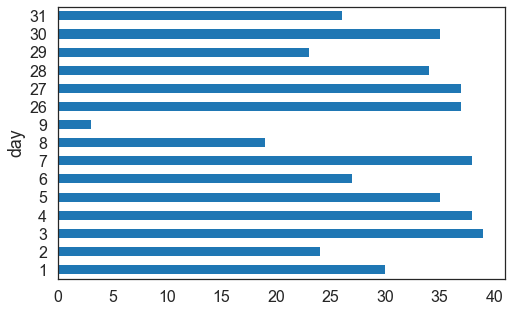

In [68]:
grp.reset_index().groupby(['day'])['name'].count().plot(kind='barh', figsize=(8, 5))

In [49]:
grp.reset_index().groupby(['day'])['name'].count().mean()

29.666666666666668

####  `pivot_table`

In [51]:
piv = tmp.pivot_table(index='day', 
                      columns='name', 
                      values='value', 
                      aggfunc='count')
piv.head()

name,zmq_waterheater_0,zmq_waterheater_113,zmq_waterheater_122,zmq_waterheater_143,zmq_waterheater_146,zmq_waterheater_148,zmq_waterheater_158,zmq_waterheater_163,zmq_waterheater_167,zmq_waterheater_170,...,zmq_waterheater_972,zmq_waterheater_974,zmq_waterheater_975,zmq_waterheater_976,zmq_waterheater_977,zmq_waterheater_98,zmq_waterheater_984,zmq_waterheater_985,zmq_waterheater_986,zmq_waterheater_993
day,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,6.0
2,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


I count because I want unique customers not total events.

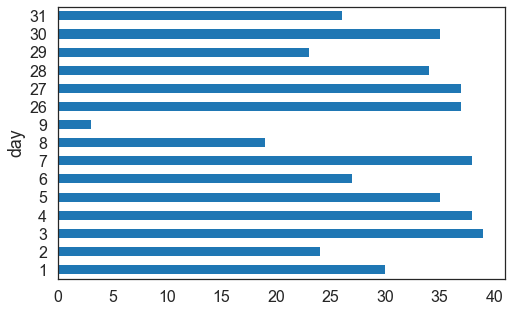

In [67]:
piv.count(axis=1).plot(kind='barh', figsize=(8, 5))

A customer was impacted more than once.

In [61]:
grp.reset_index().groupby(['day'])['name'].count().sum()

445

How many days did each customer have at least one event?

In [64]:
grp.reset_index().groupby('name')['day'].count().head()

name
zmq_waterheater_0      1
zmq_waterheater_113    1
zmq_waterheater_122    1
zmq_waterheater_143    2
zmq_waterheater_146    2
Name: day, dtype: int64

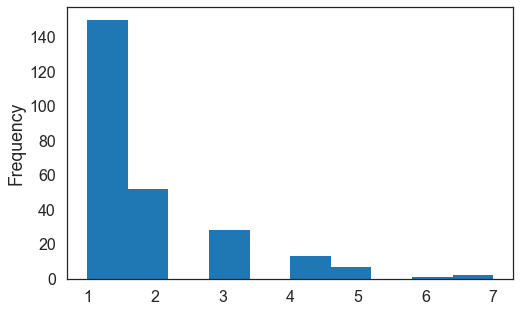

In [66]:
grp.reset_index().groupby('name')['day'].count().plot(kind='hist', figsize=(8, 5))

In [273]:
grp.groupby('name')['day'].count().sum()

445

How many events? 

In [69]:
tmp.shape

(2049, 14)

Events per customer?

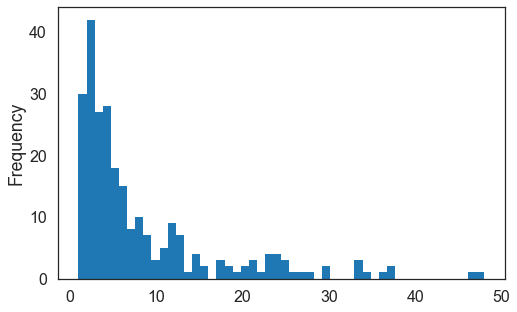

In [73]:
tmp.groupby(['name'])['value'].count().plot(kind='hist', figsize=(8, 5), bins=50)

Check on the number of events?

In [75]:
tmp.groupby(['name'])['value'].count().sum()

2049

## Question

### What is the average % of customers impacted as a function of time?

In [82]:
grp = tmp.groupby(['shift', 'day', 'name'])['value'].count()
grp.head()

shift       day  name               
-12.933333  7    zmq_waterheater_219    1
-12.916667  7    zmq_waterheater_219    1
-11.366667  26   zmq_waterheater_423    1
-11.350000  31   zmq_waterheater_908    1
-11.333333  31   zmq_waterheater_908    1
Name: value, dtype: int64

In [83]:
grp2 = grp.reset_index().reset_index().groupby(['shift', 'day'])['value'].sum()
grp2.head()

shift       day
-12.933333  7      1
-12.916667  7      1
-11.366667  26     1
-11.350000  31     1
-11.333333  31     1
Name: value, dtype: int64

Make a pivot of the number of events per day (columns) as a function of shift (rows)

In [88]:
piv = grp2.reset_index().pivot_table(index='shift', 
                                     columns='day', 
                                     values='value').fillna(0)
piv.head()

day,1,2,3,4,5,6,7,8,9,26,27,28,29,30,31
shift,,,,,,,,,,,,,,,
-12.933333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-12.916667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-11.366667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
-11.350000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
-11.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Check on the number of events.

In [90]:
piv.sum().sum()

2049.0

Events per minute.

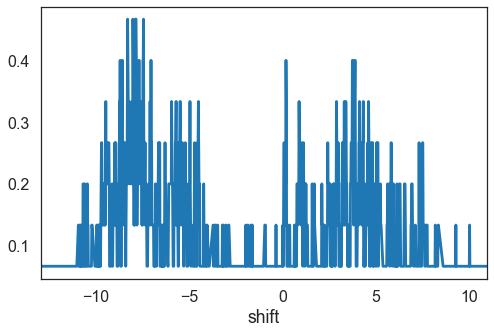

In [92]:
piv.mean(axis=1).plot( figsize=(8, 5))

####  What did we do?

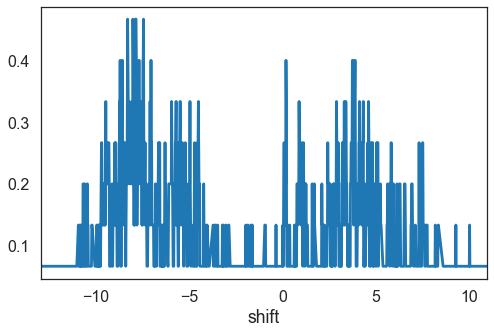

In [125]:
final = (tmp.groupby(['shift', 'day', 'name'])['value'].count()
            .reset_index().reset_index().groupby(['shift', 'day'])['value'].sum()
            .reset_index().pivot_table(index='shift', 
                                       columns='day', 
                                       values='value').fillna(0)
            .mean(axis=1)
)

final.plot( figsize=(8, 5))

Using the multi-level pivot.

In [126]:
piv = tmp.pivot_table(index='shift', 
                      columns=['day', 'name'],
                      values='value', 
                      aggfunc='count')
piv.head()

day                        1                                           \
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.933333                NaN                 NaN                 NaN   
-12.916667                NaN                 NaN                 NaN   
-11.366667                NaN                 NaN                 NaN   
-11.350000                NaN                 NaN                 NaN   
-11.333333                NaN                 NaN                 NaN   

day                                                                     \
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 NaN   
-11.333333                 NaN                 NaN                 NaN   

day                                                                   \
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.933333               NaN                 NaN                 NaN   
-12.916667               NaN                 NaN                 NaN   
-11.366667               NaN                 NaN                 NaN   
-11.350000               NaN                 NaN                 NaN   
-11.333333               NaN                 NaN                 NaN   

day                                    ...                          31  \
name       zmq_waterheater_561         ...         zmq_waterheater_721   
shift                                  ...                               
-12.933333                 NaN         ...                         NaN   
-12.916667                 NaN         ...                         NaN   
-11.366667                 NaN         ...                         NaN   
-11.350000                 NaN         ...                         NaN   
-11.333333                 NaN         ...                         NaN   

day                                                                     \
name       zmq_waterheater_744 zmq_waterheater_802 zmq_waterheater_849   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 NaN   
-11.333333                 NaN                 NaN                 NaN   

day                                                                     \
name       zmq_waterheater_863 zmq_waterheater_876 zmq_waterheater_908   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 1.0   
-11.333333                 NaN                 NaN                 1.0   

day                                                                     
name       zmq_waterheater_935 zmq_waterheater_946 zmq_waterheater_971  
shift                                                                   
-12.933333                 NaN                 NaN                 NaN  
-12.916667                 NaN                 NaN                 NaN  
-11.366667                 NaN                 NaN                 NaN  
-11.350000                 N

In [127]:
piv.sum(axis=1).head()

shift
-12.933333    1.0
-12.916667    1.0
-11.366667    1.0
-11.350000    1.0
-11.333333    1.0
dtype: float64

In [128]:
piv.sum(axis=1, level=0).head()

day,1,2,3,4,5,6,7,8,9,26,27,28,29,30,31
shift,,,,,,,,,,,,,,,
-12.933333,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-12.916667,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-11.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
-11.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
-11.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [129]:
piv1 = piv.sum(axis=1, level=0).fillna(0)
piv1.head()

day,1,2,3,4,5,6,7,8,9,26,27,28,29,30,31
shift,,,,,,,,,,,,,,,
-12.933333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-12.916667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-11.366667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
-11.350000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
-11.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


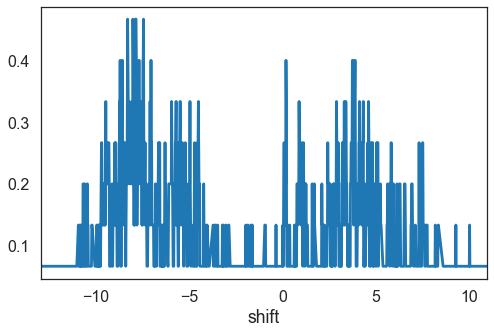

In [130]:
piv1.mean(axis=1).plot(figsize=(8, 5))

Recap in 4 steps

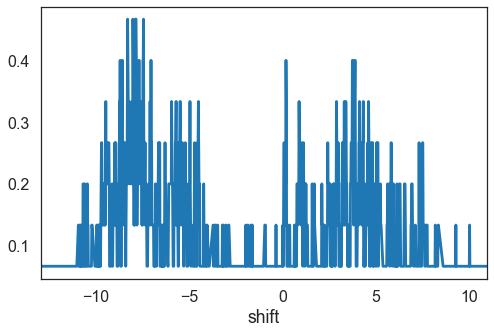

In [131]:
final = (tmp.pivot_table(index='shift', 
                         columns=['day', 'name'],
                         values='value', 
                         aggfunc='count')
            .sum(axis=1, level=0)
            .fillna(0))
        
final.mean(axis=1).plot(figsize=(8, 5))

Number of events every 10 minutes.

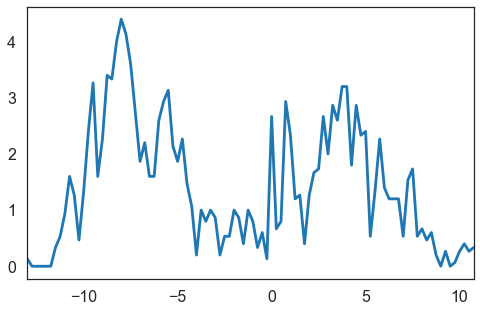

In [132]:
dt_index = (pd.to_datetime("2013-07-01 13:00:00") + 
            final.index.map(lambda x: datetime.timedelta(hours=x)))

sample = final.set_index(dt_index).resample('15min').sum().fillna(0)
sample.index = (sample.index - pd.to_datetime("2013-07-01 13:00:00")).map(lambda x: x.total_seconds()/60./60.)

sample.mean(axis=1).plot(figsize=(8, 5))

What we did..

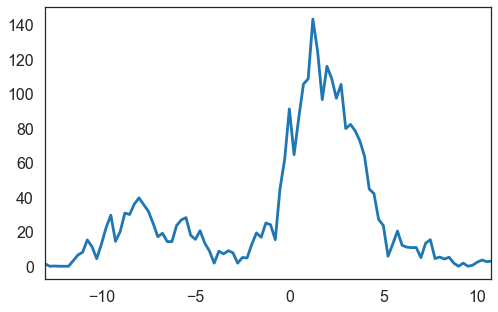

In [147]:
final = tmp.pivot_table(index='shift', columns=['day', 'name'], values='value', aggfunc='count')
            
final = final.sum(axis=1, level=0).fillna(0)

dt_index = pd.to_datetime("2013-07-01 13:00:00") + final.index.map(lambda x: datetime.timedelta(hours=x))
sample = final.set_index(dt_index).resample('15min').sum().fillna(0)
sample.index = (sample.index - pd.to_datetime("2013-07-01 13:00:00")).map(lambda x: x.total_seconds()/60./60.)

sample.mean(axis=1).plot(figsize=(8, 5))

## Many simulations

In [141]:
qry = ["feeder=='one'",
       "season=='summer'",
       "attribute=='shower demand 110'"]

tmp = df.query(" and ".join(qry))

In [155]:
final = tmp.pivot_table(index='shift', 
                         columns=['feeder', 'season', 'strategy', 'control', 'day', 'name'], 
                         values='value', 
                         aggfunc='count')
final.head()

feeder                    one                                          \
season                 summer                                           
strategy           no_control                                           
control                    0                                            
day                        1                                            
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.966667                NaN                 NaN                 NaN   
-12.950000                NaN                 NaN                 NaN   
-12.933333                NaN                 NaN                 NaN   
-12.916667                NaN                 NaN                 NaN   
-12.466667                NaN                 NaN                 NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.966667                 NaN                 NaN                 NaN   
-12.950000                 NaN                 NaN                 NaN   
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-12.466667                 NaN                 NaN                 NaN   

feeder                                                                \
season                                                                 
strategy                                                               
control                                                                
day                                                                    
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.966667               NaN                 NaN                 NaN   
-12.950000               NaN                 NaN                 NaN   
-12.933333               NaN                 NaN                 NaN   
-12.916667               NaN                 NaN                 NaN   
-12.466667               NaN                 NaN                 NaN   

feeder                                 ...                              \
season                                 ...                               
strategy                               ...                      smooth   
control                                ...                          75   
day                                    ...                          31   
name       zmq_waterheater_561         ...         zmq_waterheater_908   
shift                                  ...                               
-12.966667                 NaN         ...                         NaN   
-12.950000                 NaN         ...                         NaN   
-12.933333                 NaN         ...                         NaN   
-12.916667                 NaN         ...                         NaN   
-12.466667                 NaN         ...                         NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_926 zmq_waterheater_935 zmq_waterheater_937   
shift                               

In [156]:
final = final.sum(axis=1, level=[0,1,2,3,4]).fillna(0)
final.head()

feeder            one                                              ...   \
season         summer                                              ...    
strategy   no_control                                              ...    
control            0                                               ...    
day                1    2    3    4    5    6    7    8    9    26 ...    
shift                                                              ...    
-12.966667        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.950000        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.933333        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.916667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.466667        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    

feeder                                                          
season                                                          
strategy   smooth                                               
control        75                                               
day            6    7    8    9    26   27   28   29   30   31  
shift                                                           
-12.966667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.950000    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.933333    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.916667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.466667    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 135 columns]

In [167]:
dt_index = pd.to_datetime("2013-07-01 13:00:00") + final.index.map(lambda x: datetime.timedelta(hours=x))
sample = final.set_index(dt_index).resample('15min').sum().fillna(0)
sample.index = (sample.index - pd.to_datetime("2013-07-01 13:00:00")).map(lambda x: x.total_seconds()/60./60.)
sample.head()

feeder          one                                              ...          \
season       summer                                              ...           
strategy no_control                                              ...  smooth   
control          0                                               ...      75   
day              1    2    3    4    5    6    7    8    9    26 ...      6    
-13.00          0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0 ...     0.0   
-12.75          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...     0.0   
-12.50          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...     0.0   
-12.25          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...     0.0   
-12.00          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...     0.0   

feeder                                                 
season                                                 
strategy                                               
control                                                
day        7    8    9    26   27   28   29   30   31  
-13.00    4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.75    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.50    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.25    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 135 columns]

In [168]:
sample = sample.mean(axis=1, level=[0,1,2,3])
sample.head()

feeder          one                                                        \
season       summer                                                         
strategy no_control single_bucket                                  smooth   
control          0             6         25        50        75        6    
-13.00     0.133333      0.133333  0.133333  0.133333  0.133333  0.133333   
-12.75     0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   
-12.50     0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   
-12.25     0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   
-12.00     0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   

feeder                             
season                             
strategy                           
control         25   50        75  
-13.00    0.133333  0.2  0.266667  
-12.75    0.000000  0.0  0.000000  
-12.50    0.000000  0.0  0.133333  
-12.25    0.000000  0.0  0.000000  
-12.00    0.000000  0.0  0.000000

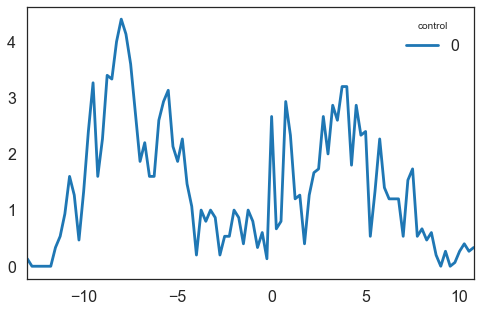

In [171]:
sample[('one', 'summer', 'no_control')].plot(figsize=(8, 5))

Look at all scenarios

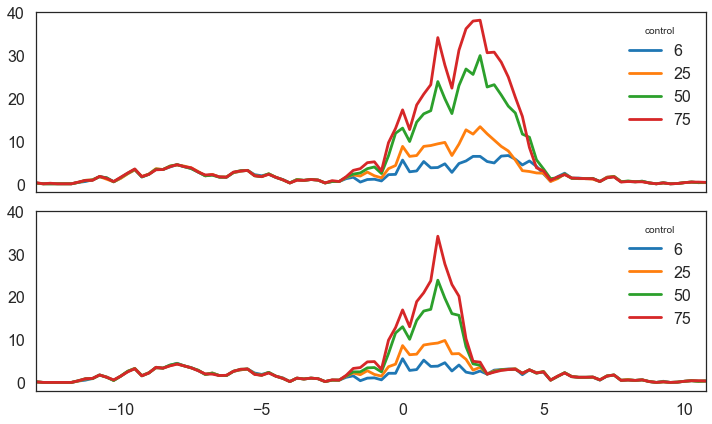

In [173]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True, sharey=True)

sample[('one', 'summer', 'smooth')].plot(ax=ax[0])
sample[('one', 'summer', 'single_bucket')].plot(ax=ax[1])

plt.tight_layout()

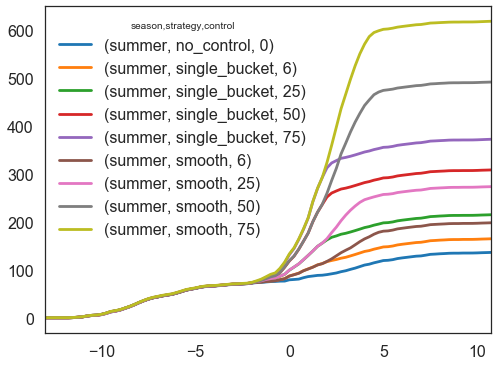

In [175]:
sample['one'].cumsum().plot(figsize=(8,6))

## Question #2

### What is the average cumulative % of customers impacted as a function of time?

Count a customer as unsatisfied only once...

Warm up

In [176]:
qry = ["feeder=='one'",
       "season=='summer'",
       "strategy=='no_control'",
       "control==0",
       "attribute=='shower demand 110'"]

tmp = df.query(" and ".join(qry))

In [177]:
counts = tmp.pivot_table(index='shift', columns=['day', 'name'], values='value', aggfunc='count')
counts.head()

day                        1                                           \
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.933333                NaN                 NaN                 NaN   
-12.916667                NaN                 NaN                 NaN   
-11.366667                NaN                 NaN                 NaN   
-11.350000                NaN                 NaN                 NaN   
-11.333333                NaN                 NaN                 NaN   

day                                                                     \
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 NaN   
-11.333333                 NaN                 NaN                 NaN   

day                                                                   \
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.933333               NaN                 NaN                 NaN   
-12.916667               NaN                 NaN                 NaN   
-11.366667               NaN                 NaN                 NaN   
-11.350000               NaN                 NaN                 NaN   
-11.333333               NaN                 NaN                 NaN   

day                                    ...                          31  \
name       zmq_waterheater_561         ...         zmq_waterheater_721   
shift                                  ...                               
-12.933333                 NaN         ...                         NaN   
-12.916667                 NaN         ...                         NaN   
-11.366667                 NaN         ...                         NaN   
-11.350000                 NaN         ...                         NaN   
-11.333333                 NaN         ...                         NaN   

day                                                                     \
name       zmq_waterheater_744 zmq_waterheater_802 zmq_waterheater_849   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 NaN   
-11.333333                 NaN                 NaN                 NaN   

day                                                                     \
name       zmq_waterheater_863 zmq_waterheater_876 zmq_waterheater_908   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 1.0   
-11.333333                 NaN                 NaN                 1.0   

day                                                                     
name       zmq_waterheater_935 zmq_waterheater_946 zmq_waterheater_971  
shift                                                                   
-12.933333                 NaN                 NaN                 NaN  
-12.916667                 NaN                 NaN                 NaN  
-11.366667                 NaN                 NaN                 NaN  
-11.350000                 N

In [179]:
def fill_first_index(df):
    zeros = np.zeros(df.shape[0])
    index = df.first_valid_index()

    if index is not None:
        tmp = pd.Series(zeros, index=df.index)
        tmp.loc[tmp.index==index] = 1.0
        return tmp
    
    return pd.Series(zeros, index=df.index)

We can `apply` this to the columns (`axis=0`) of our dataframe.

In [180]:
final = counts.apply(fill_first_index, axis=0)
final.head()

day                        1                                           \
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.933333                0.0                 0.0                 0.0   
-12.916667                0.0                 0.0                 0.0   
-11.366667                0.0                 0.0                 0.0   
-11.350000                0.0                 0.0                 0.0   
-11.333333                0.0                 0.0                 0.0   

day                                                                     \
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-11.366667                 0.0                 0.0                 0.0   
-11.350000                 0.0                 0.0                 0.0   
-11.333333                 0.0                 0.0                 0.0   

day                                                                   \
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.933333               0.0                 0.0                 0.0   
-12.916667               0.0                 0.0                 0.0   
-11.366667               0.0                 0.0                 0.0   
-11.350000               0.0                 0.0                 0.0   
-11.333333               0.0                 0.0                 0.0   

day                                    ...                          31  \
name       zmq_waterheater_561         ...         zmq_waterheater_721   
shift                                  ...                               
-12.933333                 0.0         ...                         0.0   
-12.916667                 0.0         ...                         0.0   
-11.366667                 0.0         ...                         0.0   
-11.350000                 0.0         ...                         0.0   
-11.333333                 0.0         ...                         0.0   

day                                                                     \
name       zmq_waterheater_744 zmq_waterheater_802 zmq_waterheater_849   
shift                                                                    
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-11.366667                 0.0                 0.0                 0.0   
-11.350000                 0.0                 0.0                 0.0   
-11.333333                 0.0                 0.0                 0.0   

day                                                                     \
name       zmq_waterheater_863 zmq_waterheater_876 zmq_waterheater_908   
shift                                                                    
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-11.366667                 0.0                 0.0                 0.0   
-11.350000                 0.0                 0.0                 1.0   
-11.333333                 0.0                 0.0                 0.0   

day                                                                     
name       zmq_waterheater_935 zmq_waterheater_946 zmq_waterheater_971  
shift                                                                   
-12.933333                 0.0                 0.0                 0.0  
-12.916667                 0.0                 0.0                 0.0  
-11.366667                 0.0                 0.0                 0.0  
-11.350000                 0

Check that we only have a single value per day and waterheater

In [183]:
final.sum(axis=0).unique()

array([ 1.])

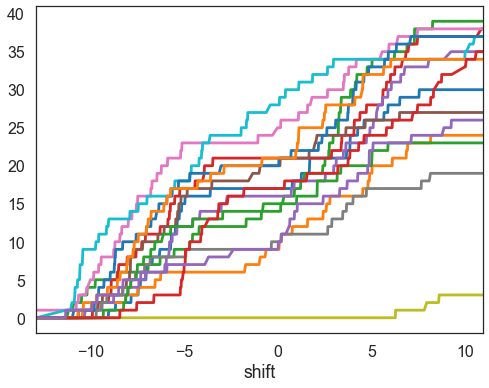

In [185]:
final.sum(axis=1, level=0).cumsum().plot(figsize=(8, 6), legend=False)

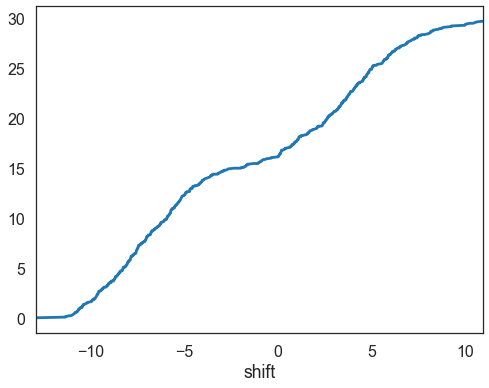

In [186]:
final.sum(axis=1, level=0).cumsum().mean(axis=1).plot(figsize=(8, 6))

Remember this number?

## Multiple scenarios

In [189]:
qry = ["feeder=='one'",
       "season=='summer'",
       "attribute=='shower demand 110'"]

tmp = df.query(" and ".join(qry))

In [190]:
counts = tmp.pivot_table(index='shift', 
                         columns=['feeder', 'season', 'strategy', 'control', 'day', 'name'], 
                         values='value', aggfunc='count')
counts.head()

feeder                    one                                          \
season                 summer                                           
strategy           no_control                                           
control                    0                                            
day                        1                                            
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.966667                NaN                 NaN                 NaN   
-12.950000                NaN                 NaN                 NaN   
-12.933333                NaN                 NaN                 NaN   
-12.916667                NaN                 NaN                 NaN   
-12.466667                NaN                 NaN                 NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.966667                 NaN                 NaN                 NaN   
-12.950000                 NaN                 NaN                 NaN   
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-12.466667                 NaN                 NaN                 NaN   

feeder                                                                \
season                                                                 
strategy                                                               
control                                                                
day                                                                    
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.966667               NaN                 NaN                 NaN   
-12.950000               NaN                 NaN                 NaN   
-12.933333               NaN                 NaN                 NaN   
-12.916667               NaN                 NaN                 NaN   
-12.466667               NaN                 NaN                 NaN   

feeder                                 ...                              \
season                                 ...                               
strategy                               ...                      smooth   
control                                ...                          75   
day                                    ...                          31   
name       zmq_waterheater_561         ...         zmq_waterheater_908   
shift                                  ...                               
-12.966667                 NaN         ...                         NaN   
-12.950000                 NaN         ...                         NaN   
-12.933333                 NaN         ...                         NaN   
-12.916667                 NaN         ...                         NaN   
-12.466667                 NaN         ...                         NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_926 zmq_waterheater_935 zmq_waterheater_937   
shift                               

In [191]:
first = counts.apply(fill_first_index, axis=0)
first.head()

feeder                    one                                          \
season                 summer                                           
strategy           no_control                                           
control                    0                                            
day                        1                                            
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.966667                0.0                 0.0                 0.0   
-12.950000                0.0                 0.0                 0.0   
-12.933333                0.0                 0.0                 0.0   
-12.916667                0.0                 0.0                 0.0   
-12.466667                0.0                 0.0                 0.0   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.966667                 0.0                 0.0                 0.0   
-12.950000                 0.0                 0.0                 0.0   
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-12.466667                 0.0                 0.0                 0.0   

feeder                                                                \
season                                                                 
strategy                                                               
control                                                                
day                                                                    
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.966667               0.0                 0.0                 0.0   
-12.950000               0.0                 0.0                 0.0   
-12.933333               0.0                 0.0                 0.0   
-12.916667               0.0                 0.0                 0.0   
-12.466667               0.0                 0.0                 0.0   

feeder                                 ...                              \
season                                 ...                               
strategy                               ...                      smooth   
control                                ...                          75   
day                                    ...                          31   
name       zmq_waterheater_561         ...         zmq_waterheater_908   
shift                                  ...                               
-12.966667                 0.0         ...                         0.0   
-12.950000                 0.0         ...                         0.0   
-12.933333                 0.0         ...                         0.0   
-12.916667                 0.0         ...                         0.0   
-12.466667                 0.0         ...                         0.0   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_926 zmq_waterheater_935 zmq_waterheater_937   
shift                               

In [192]:
first.sum(axis=1, level=[0,1,2,3,4]).cumsum().head()

feeder            one                                              ...   \
season         summer                                              ...    
strategy   no_control                                              ...    
control            0                                               ...    
day                1    2    3    4    5    6    7    8    9    26 ...    
shift                                                              ...    
-12.966667        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.950000        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.933333        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.916667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.466667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    

feeder                                                          
season                                                          
strategy   smooth                                               
control        75                                               
day            6    7    8    9    26   27   28   29   30   31  
shift                                                           
-12.966667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.950000    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.933333    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.916667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.466667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 135 columns]

In [193]:
final = first.sum(axis=1, level=[0,1,2,3,4]).cumsum().mean(axis=1, level=[0,1,2,3])

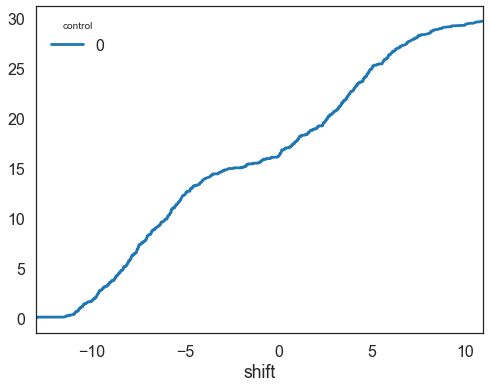

In [195]:
final[('one', 'summer', 'no_control')].plot(figsize=(8, 6))

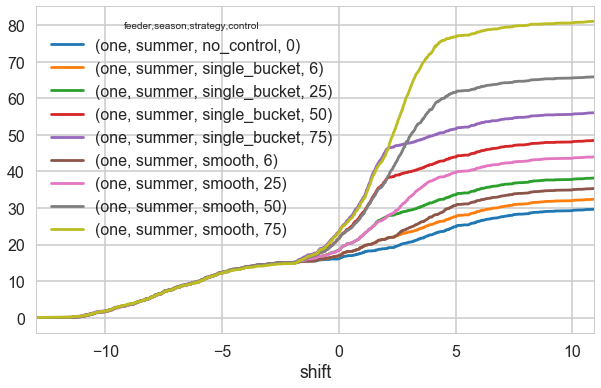

In [197]:
plt.style.use("seaborn-whitegrid")
final.plot(figsize=(10, 6))

In [198]:
stack = pd.melt(final.reset_index(), id_vars=['shift'])
stack.head()

,shift,feeder,season,strategy,control,value
0,-12.966667,one,summer,no_control,0,0.000000
1,-12.950000,one,summer,no_control,0,0.000000
2,-12.933333,one,summer,no_control,0,0.066667
3,-12.916667,one,summer,no_control,0,0.066667
4,-12.466667,one,summer,no_control,0,0.066667


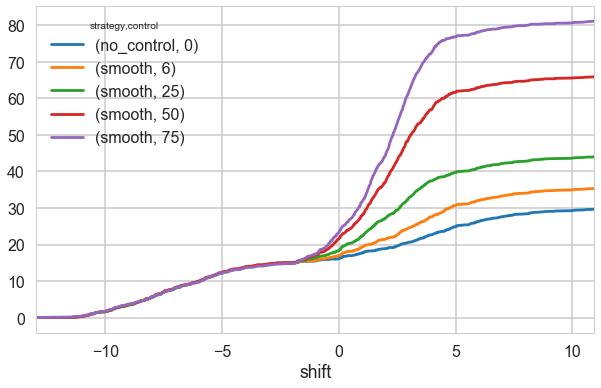

In [199]:
(stack.query("strategy in ['no_control', 'smooth']")
      .pivot_table(index='shift', 
                   columns=['strategy', 'control'], 
                   values='value')).plot(figsize=(10, 6))

Table, plots, summary plots: 29, 30, 31, 33, table 7